In [28]:
import numpy as np
import psycopg2
import hdf5storage
import h5py
import pickle
import logging
from sys import getsizeof
from dotenv import dotenv_values
import dask.array as da
from dask.distributed import Client, LocalCluster


config = dotenv_values("../.env")
# Filepaths for script
filepath = config["currentDirectory"] +"data/archivedDataSets/ContiguousAssembly/"
outfileName = "OutputTrajectories"

In [29]:
# Trial Parameters
trials = 40
timesteps = 1500


In [30]:
client = Client('tcp://127.0.0.1:8786')
client.cluster


In [31]:
####### Load in data #######
print("Loading in data...")
# Read in all training data 
data = h5py.File(filepath+ "FreqSweepDataset.hdf5", 'r')
print(list(data.keys()))
Y_fom = da.from_array(data["outputData"], chunks=(4096, 4096,1))
y0 = data["outputData"][:,0,0]
m = Y_fom.shape[0]
# # Collect initial condition offsets for each episode and center each episode about that initial condition
Y0 = da.zeros((m,trials))
for i in range(trials):
    Y0[:,i] = Y_fom[:,0,i]
print("Done loading in data.")


Loading in data...
['inputData', 'outputData', 'simulationTimes', 'simulationTimesteps', 'stateData']
Done loading in data.


In [50]:
# Grab dimension of stateData
data["stateData"].shape

(243789, 1000, 40)

In [32]:
# Center data around neutral position of robot
Y_fom = Y_fom - Y0[:,0].reshape(-1,1,1)

In [41]:
# Plot output trajectories from trial i on a 2 column figure
def plotTrajectories(Y_fom, i):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(20, 2, figsize=(10,40))
    for j in range(20):
        for k in range(2):
            ax[j,k].plot(Y_fom[j*2+k,:,i])
            ax[j,k].set_title(f"Trial {i+1}, Output {j*2+k+1}")
            ax[j,k].set_xlabel("Time")
            ax[j,k].set_ylabel("Output")
    plt.tight_layout()
    plt.show()

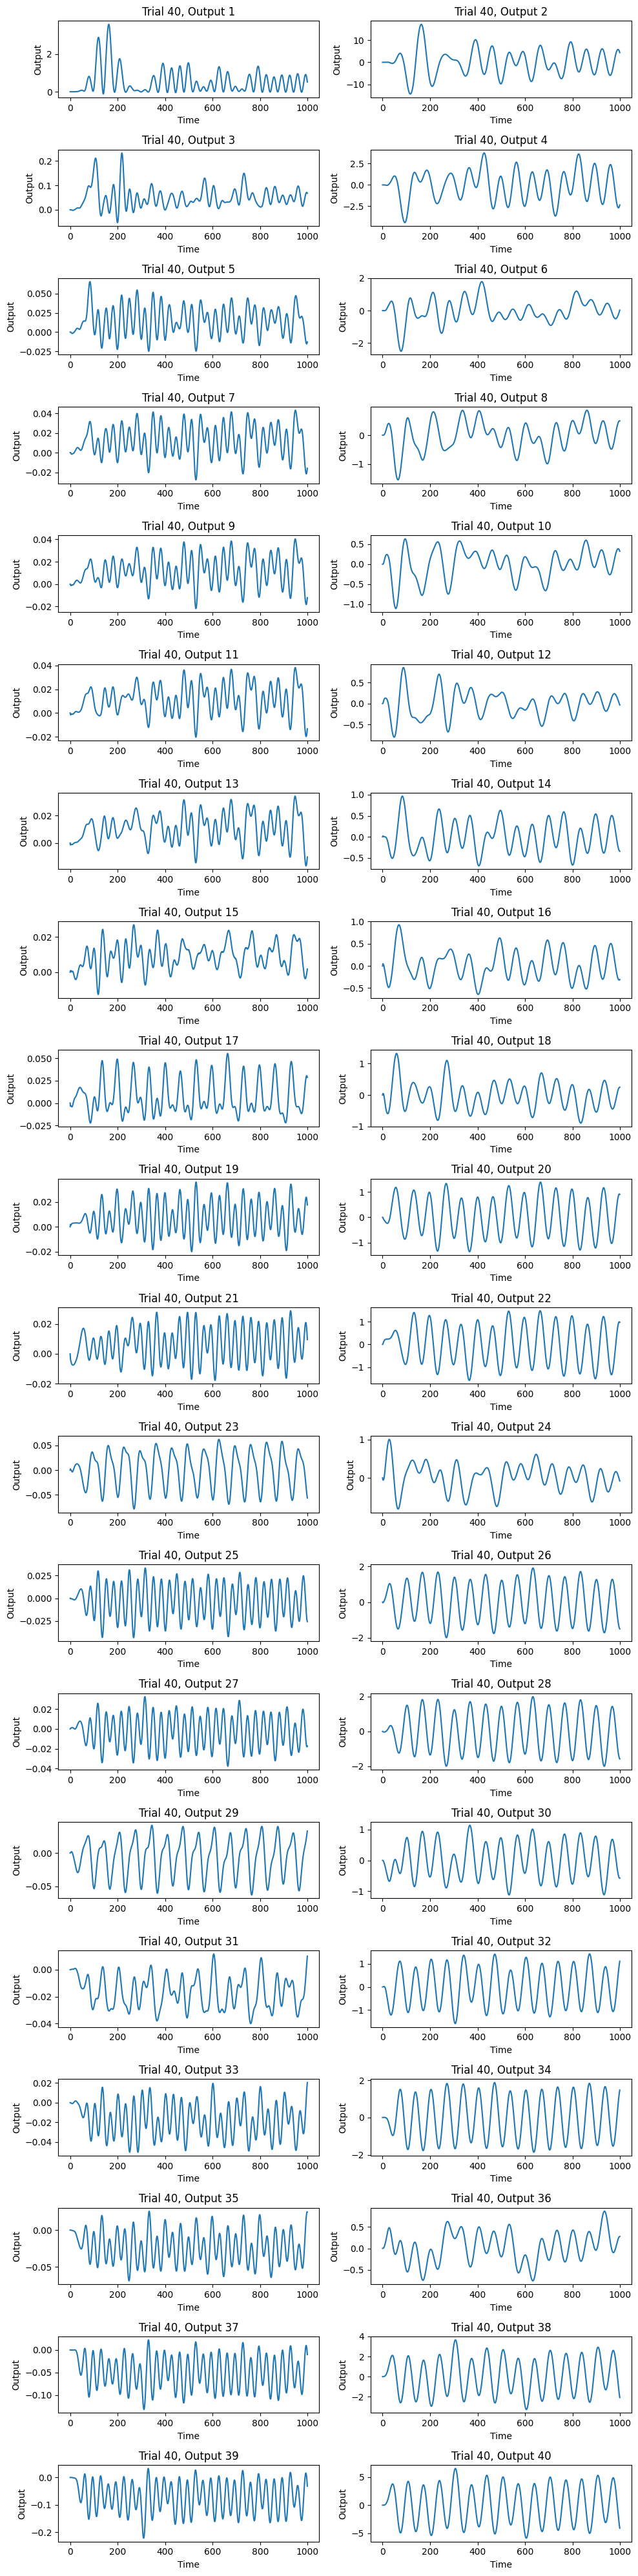

In [42]:
plotTrajectories(Y_fom.compute(), 39)

In [20]:
Y_fom.compute().shape

(40, 1000, 40)

In [ ]:
# Save data in pickle file
print("Saving data...")
with open(filepath+outfileName+'.pkl', 'wb') as f:
    pickle.dump(Y_fom.compute(), f)
print("Done saving data.")
client.close()
print("Done.")

Saving data...
Done saving data.
Done.


In [46]:
# Helper function to read in file and grab n timesteps of outputs starting from index i
def getTimestepsFromFile(filepath, i, n,trialNum):
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    return data[:,i:i+n,trialNum]

# Test out function
getTimestepsFromFile(filepath+outfileName+'.pkl', 0, 10, 0).shape


(40, 10)